In [1]:
import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from itertools import permutations

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # has wide Unicode support

# Modelling
from cf_plus_core import diagnose_inputs, CFPlus, CFPlusConfig, build_fit_predict, validation_curve_df, penalty_report_monthyear

# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

# Load Data

##  Meta SCI - VE missing
Source: https://data.humdata.org/dataset/social-connectedness-index

In [2]:
df_SCI = pd.read_csv(DATA_DIR/f"Migration/Excess/countries-countries-fb-social-connectedness-index-october-2021.tsv", sep="\t") 
# df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_SCI

,user_loc,fr_loc,scaled_sci
0,AE,AE,1117179
1,AE,AG,5488
2,AE,AL,2101
3,AE,AM,3580
4,AE,AO,2326
...,...,...,...
34220,ZW,XK,262
34221,ZW,YT,1650
34222,ZW,ZA,366466
34223,ZW,ZM,196035


In [3]:
# Collect all unique country codes from SCI
sci_countries = set(df_SCI["user_loc"].unique()) | set(df_SCI["fr_loc"].unique())

# Collect all unique country codes from migration data
migration_countries = set(df["country_from"].unique()) | set(df["country_to"].unique())

# Countries in SCI but not in migration
missing_in_migration = sci_countries - migration_countries

# Countries in migration but not in SCI
missing_in_sci = migration_countries - sci_countries

print("Countries in SCI but missing in migration:")
print(sorted(missing_in_migration))

print("\nCountries in migration but missing in SCI:")
print(sorted(missing_in_sci))

NameError: name 'df' is not defined

## Meta Migration 

In [2]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Unique list from both columns
unique_countries = pd.unique(df[["country_from", "country_to"]].values.ravel())

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [3]:
# Keep only what we need and rename to the model’s expected names
df_flow = (df
      .rename(columns={
          "country_from": "orig",
          "country_to": "dest",
          # "migration_month": "month",
          "num_migrants": "flow"
      })
      [["orig", "dest", "migration_month", "flow"]].copy()).rename(columns={
          "migration_month": "month"      })

# Make sure month is monthly datetime (month-start)
# df_flow["month"] = pd.to_datetime(df["month"]).dt.to_period("M").dt.to_timestamp()

# Clean types
df_flow["orig"] = df_flow["orig"].astype(str).str.upper()
df_flow["dest"] = df_flow["dest"].astype(str).str.upper()
df_flow["flow"] = pd.to_numeric(df_flow["flow"], errors="coerce").fillna(0).clip(lower=0).astype(int)

# If there are accidental duplicates (same orig-dest-month), aggregate
# df_flow = (df_flow.groupby(["orig", "dest", "month"], as_index=False)["flow"].sum())

df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


## Country alpha2/3

In [4]:
df_country = pd.read_csv(DATA_DIR/f"all.csv") 
df_country = df_country[['name', 'alpha-2', 'alpha-3', 
                         'region', 'sub-region']]

df_country = df_country[df_country["alpha-2"].isin(unique_countries)]
df_country

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
5,Andorra,AD,AND,Europe,Southern Europe
6,Angola,AO,AGO,Africa,Sub-Saharan Africa
...,...,...,...,...,...
240,"Venezuela, Bolivarian Republic of",VE,VEN,Americas,Latin America and the Caribbean
241,Viet Nam,VN,VNM,Asia,South-eastern Asia
246,Yemen,YE,YEM,Asia,Western Asia
247,Zambia,ZM,ZMB,Africa,Sub-Saharan Africa


## Population 
Source: World Bank  
https://data.worldbank.org/indicator/SP.POP.TOTL

In [5]:
df_pop = pd.read_csv(DATA_DIR/f"Migration/Excess/API_SP.POP.TOTL_DS2_en_csv_v2_710977.csv") 
df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_pop

,Country Code,2019,2020,2021,2022
0,ABW,109203.0,108587.0,107700.0,107310.0
1,AFE,675950189.0,694446100.0,713090928.0,731821393.0
2,AFG,37856121.0,39068979.0,40000412.0,40578842.0
3,AFW,463365429.0,474569351.0,485920997.0,497387180.0
4,AGO,32375632.0,33451132.0,34532429.0,35635029.0
...,...,...,...,...,...
261,XKX,1788891.0,1790151.0,1786079.0,1768096.0
262,YEM,35111408.0,36134863.0,37140230.0,38222876.0
263,ZAF,59587885.0,60562381.0,61502603.0,62378410.0
264,ZMB,18513839.0,19059395.0,19603607.0,20152938.0


In [6]:
# Make a mapping dictionary: alpha-3 → alpha-2
alpha_map = dict(zip(df_country["alpha-3"], df_country["alpha-2"]))

# Map alpha-3 to alpha-2
df_pop["Country Code"] = df_pop["Country Code"].map(alpha_map)

# Drop rows where mapping failed (NaN values in Country Code)
df_pop = df_pop.dropna(subset=["Country Code"]).reset_index(drop=True)

df_pop

,Country Code,2019,2020,2021,2022
0,AF,37856121.0,39068979.0,40000412.0,40578842.0
1,AO,32375632.0,33451132.0,34532429.0,35635029.0
2,AL,2854191.0,2837849.0,2811666.0,2777689.0
3,AD,76474.0,77380.0,78364.0,79705.0
4,AE,9445785.0,9401038.0,9575152.0,10074977.0
...,...,...,...,...,...
173,WS,209780.0,211944.0,213779.0,215261.0
174,YE,35111408.0,36134863.0,37140230.0,38222876.0
175,ZA,59587885.0,60562381.0,61502603.0,62378410.0
176,ZM,18513839.0,19059395.0,19603607.0,20152938.0


In [7]:
# Convert to long format
df_pop_long = df_pop.melt(id_vars=["Country Code"], 
                  var_name="Year", 
                  value_name="Population")

# After melting into long format (df_long)
df_pop_long = df_pop_long.rename(columns={
    "Country Code": "iso3",
    "Year": "year",
    "Population": "population"
})

df_pop_long

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


## Prep

In [8]:
# Get unique country codes from both datasets
pop_codes = set(df_pop["Country Code"].unique())
flow_codes = set(df_flow["orig"].unique()) | set(df_flow["dest"].unique())

# Find differences
missing_in_pop = flow_codes - pop_codes
missing_in_flow = pop_codes - flow_codes

print("✅ Country codes in flow but missing in pop:")
print(missing_in_pop if missing_in_pop else "None")

print("\n✅ Country codes in pop but missing in flow:")
print(missing_in_flow if missing_in_flow else "None")

✅ Country codes in flow but missing in pop:
{'TW', 'NAN', 'XK'}

✅ Country codes in pop but missing in flow:
None


In [9]:
print("✅ Before cleaning:", len(df_flow))

# Allowed country codes (from df_pop)
valid_codes = set(df_pop["Country Code"].unique())

# Keep only rows where both orig and dest are in df_pop
df_flow = df_flow[
    df_flow["orig"].isin(valid_codes) & df_flow["dest"].isin(valid_codes)
].copy()

print("✅ After cleaning:", len(df_flow))

✅ Before cleaning: 1563154
✅ After cleaning: 1511698


## Smaller Set 

### Latin America countries

In [13]:
# selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

selected_countries = [
    # South America
    'AR',  # Argentina
    'BO',  # Bolivia
    'BR',  # Brazil
    'CL',  # Chile
    'CO',  # Colombia
    'EC',  # Ecuador
    'GY',  # Guyana
    'PY',  # Paraguay
    'PE',  # Peru
    'SR',  # Suriname
    'UY',  # Uruguay
    'VE',  # Venezuela

    # # Central America
    # 'BZ',  # Belize
    'CR',  # Costa Rica
    # 'SV',  # El Salvador
    # 'GT',  # Guatemala
    # 'HN',  # Honduras
    'NI',  # Nicaragua
    'PA',  # Panama

    # Mexico
    'MX',  # Mexico

    # Caribbean (Latin)
    'CU',  # Cuba
    'DO',  # Dominican Republic
    'PR',  # Puerto Rico (US territory but culturally Latin)
    'HT',  # Haiti (French/Creole-speaking, sometimes included)

    # Manually add US & CA
    'US','CA','ES'
]

# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
5,AR,2019,44973465.0
21,BO,2019,11671386.0
22,BR,2019,207455459.0
28,CA,2019,37618495.0
30,CL,2019,19197744.0
...,...,...,...
666,PY,2022,6760464.0
681,SR,2022,623164.0
700,UY,2022,3390913.0
701,US,2022,334017321.0


### European countries

In [11]:
selected_countries = [
    # European Union (EU) - Northern Europe
    'DK',  # Denmark
    'EE',  # Estonia
    'FI',  # Finland
    'IE',  # Ireland
    'LV',  # Latvia
    'LT',  # Lithuania
    'SE',  # Sweden

    # European Union (EU) - Western Europe
    'AT',  # Austria
    'BE',  # Belgium
    'FR',  # France
    'DE',  # Germany
    'LU',  # Luxembourg
    'NL',  # Netherlands

    # European Union (EU) - Southern Europe
    'HR',  # Croatia
    'CY',  # Cyprus
    'GR',  # Greece
    'IT',  # Italy
    'MT',  # Malta
    'PT',  # Portugal
    'SI',  # Slovenia
    'ES',  # Spain

    # # European Union (EU) - Central & Eastern Europe
    # 'BG',  # Bulgaria
    # 'CZ',  # Czechia (Czech Republic)
    # 'HU',  # Hungary
    # 'PL',  # Poland
    # 'RO',  # Romania
    # 'SK',  # Slovakia

    # # European Union (EU) - Recent Members
    # 'HR',  # Croatia (joined 2013)
]
# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
8,AT,2019,8879920.0
11,BE,2019,11488980.0
39,CY,2019,1286671.0
41,DE,2019,83092962.0
43,DK,2019,5814422.0
...,...,...,...
642,MT,2022,531113.0
654,NL,2022,17700982.0
665,PT,2022,10434332.0
683,SI,2022,2112076.0


## Set flow 

In [10]:
# For all
flows_filtered = df_flow
pops_filtered = df_pop_long

In [14]:
# # Filter selected flows data 
# # both orig and dest must be in selected countries
# flows_filtered = df_flow[
#     df_flow['orig'].isin(selected_countries) & df_flow['dest'].isin(selected_countries)
# ].copy()

# print("\nFiltered flow data:")
# flows_filtered


Filtered flow data:


,orig,dest,month,flow
52750,AR,BO,2019-01-01,3325
52751,AR,BO,2019-02-01,3275
52752,AR,BO,2019-03-01,2686
52753,AR,BO,2019-04-01,2089
52754,AR,BO,2019-05-01,2084
...,...,...,...,...
1493597,VE,UY,2022-08-01,122
1493598,VE,UY,2022-09-01,121
1493599,VE,UY,2022-10-01,161
1493600,VE,UY,2022-11-01,149


In [15]:
# df_flow.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv", index=False)

# Check Data

In [11]:
report = diagnose_inputs(df_flow, df_pop_long)
report

,value
flows_min_month,2019-01-01 00:00:00
flows_max_month,2022-12-01 00:00:00
n_rows_flows,1511698
n_pairs,31496
rows_year_2019,377921
rows_year_2020,377923
rows_year_2021,377926
rows_year_2022,377928
pop_cols,"iso3,population,year"
n_countries_flows,178


In [12]:
# Optional: Sanity checks that avoid NaNs and bad splits

print(df_flow['month'].min(), df_flow['month'].max())
print(df_pop_long[['iso3','year']].drop_duplicates().head())

2019-01-01 00:00:00 2022-12-01 00:00:00
  iso3  year
0   AF  2019
1   AO  2019
2   AL  2019
3   AD  2019
4   AE  2019


#  Counterfactual

In [13]:
# Selected data
flows = flows_filtered
pops = pops_filtered

# Full data
# flows = df_flow
# pops = df_pop_long

# Sample data
# flows = pd.read_csv("flows_sample.csv")     # orig, dest, month, flow
# pops  = pd.read_csv("pops_sample.csv")      # iso3, year, population

pops

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


| Parameter                | Type / Example                          |                                         Default | What it controls                                                                           | When to change                                                                                     |
| ------------------------ | --------------------------------------- | ----------------------------------------------: | ------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------- |
| `train_end`              | `str` date, e.g. `"2021-12-01"`         |                                  `"2021-12-01"` | Last month included in training (inclusive).                                               | Set to the end of your intended training window. Ensure your data covers it.                       |
| `val_start`              | `str` date, e.g. `"2021-07-01"`         |                                  `"2021-07-01"` | Start of the **validation slice** inside training, used to pick `alpha`.                   | Use a late subset (last 6–12 months of training). If too short, the code falls back automatically. |
| `baseline_years`         | `tuple[int]`, e.g. `(2019, 2020, 2021)` |                                       `(2019,)` | Years used to compute the month‑of‑year seasonal profile `S_m`.                            | If 2019 is sparse, include additional years (e.g., 2019–2021).                                     |
| `alphas`                 | `tuple[float]`, e.g. `(1e-6, …, 1.0)`   | `(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0)` | L2 regularization strengths searched on the validation slice.                              | If you see convergence warnings or overfit, include larger values (e.g., `1.0, 2.0`).              |
| `standardize_continuous` | `bool`                                  |                                          `True` | Whether to standardize continuous features (`log_pop_o`, `log_pop_d`, `H_t`, `covid_idx`). | Leave `True` unless you have pre‑standardized inputs.                                              |
| `use_external_covid`     | `bool`                                  |                                         `False` | Whether to include an external monthly COVID index (`covid_df['covid_idx']`).              | Set `True` if you supply `covid_df`; otherwise keep `False`.                                       |
| `max_iter`               | `int`                                   |                                         `20000` | Max iterations for the Poisson optimizer (LBFGS).                                          | Increase if you still see `ConvergenceWarning`.                                                    |
| `tol`                    | `float`                                 |                                          `1e-7` | Tolerance for optimizer convergence.                                                       | Tighten if you want stricter convergence; loosen for speed.                                        |
| `progress`               | `bool`                                  |                                          `True` | Shows a `tqdm` progress bar for the alpha grid.                                            | Set `False` for quiet logs (e.g., batch runs).                                                     |


Practical tips (to avoid the common pain points)
- Codecs match: Make sure df_flow['orig','dest'] and df_pop_long['iso3'] use the same code system (ISO3 if you follow the write‑up). If yours are ISO2, convert one side.
- Seasonality baseline: If baseline years are empty or zero, the code falls back to a flat seasonal profile (S_m ≡ 1) so H_t stays finite.
- Population gaps: Missing population values get imputed with the year‑median across countries (then log‑transformed). You can swap in your preferred population series.
- Convergence: Remaining ConvergenceWarnings are usually benign, but you can raise max_iter, and/or bias to larger alphas.
- External shocks: If you pass an external covid_df, it will be added as another global signal alongside the learned H_t. If you prefer to use only the external index, set baseline_years=() and overwrite H_t with zeros in a small wrapper.

In [14]:
# 1) Fit
cfg = CFPlusConfig(train_end="2022-12-01",  # end of training window (inclusive)
                   val_start="2021-07-01",  # late-slice inside training for alpha selection
                   alphas=(1e-6,1e-5,1e-4,1e-3), 
                     # alphas=(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0),
                   max_iter=20000, tol=1e-7,       # convergence knobs
                   progress=False)
cf, design, pred = build_fit_predict(flows, pops, cfg)

# design - analysis-ready data
# pred - prediction output

pred

/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12388 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12414 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


,orig,dest,month,flow,mu_hat,excess_pct
0,AD,AE,2019-01-01,12.0,5.775084,1.077892
1,AD,AE,2019-02-01,2.0,6.478407,-0.691282
2,AD,AE,2019-03-01,1.0,7.266573,-0.862384
3,AD,AE,2019-04-01,7.0,6.926627,0.010593
4,AD,AE,2019-05-01,0.0,6.662004,-1.000000
...,...,...,...,...,...,...
1511803,ZW,ZM,2022-08-01,138.0,131.921708,0.046075
1511804,ZW,ZM,2022-09-01,162.0,123.823438,0.308315
1511805,ZW,ZM,2022-10-01,149.0,153.194337,-0.027379
1511806,ZW,ZM,2022-11-01,104.0,123.159540,-0.155567


In [15]:
# 2) Validation curve (no re-fitting)
vc = validation_curve_df(cf)
print(vc)
print("Best alpha:", cf.best_alpha_)

      alpha    val_mae
0  0.000001  50.332203
1  0.000010  50.367229
2  0.000100  50.808920
3  0.001000  56.115400
Best alpha: 1e-06


In [16]:
# 3) Penalty + deviance (once)
rep = penalty_report_monthyear(cf, return_deviance=True,
                               flows_df=flows, pop_df=pops)
print(rep)

{'alpha': 1e-06, 'groups_sq': {'||theta||^2': 66605.61491827412, '||month_year||^2': 5.807458519107363, 'beta_log_pop_o': 0.0029744627537572946, 'beta_log_pop_d': 0.0029744627537572946}, 'sum_sq_all': 66611.42832571873, 'penalty_value_sklearn': 0.033305714162859365, 'penalty_value_alpha_sum': 0.06661142832571873, 'continuous_coefs_original_scale': {'beta_log_pop_o': 0.054538635422581805, 'beta_log_pop_d': 0.054538635422581805}, 'train_poisson_deviance': 41601190.37187343, 'train_objective_value': 41601190.40517914}


In [17]:
pred[pred['flow'] >= 1000].sort_values(by="excess_pct", ascending=False) 

,orig,dest,month,flow,mu_hat,excess_pct
573139,HK,KH,2020-08-01,2215.0,63.986187,33.616847
1407314,UG,OM,2019-03-01,3677.0,123.957294,28.663442
573140,HK,KH,2020-09-01,2898.0,97.745772,28.648341
708595,KG,IN,2020-08-01,2095.0,76.823956,26.270139
431958,ET,SY,2019-07-01,5177.0,222.227520,22.295945
...,...,...,...,...,...,...
1456255,VN,JP,2021-08-01,1003.0,10164.218625,-0.901321
1456259,VN,JP,2021-12-01,1014.0,10276.353477,-0.901327
1456260,VN,JP,2022-01-01,1363.0,14110.070479,-0.903402
1394840,UA,DE,2019-09-01,1062.0,11377.004917,-0.906654


# Export / Readin 

In [3]:
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv", index=False)
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv", index=False)
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_ALL.csv", index=False)

# pred_EU = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv") 
# pred_LA = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv") 
pred_ALL = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_ALL.csv") 

In [18]:
# Single corridor
corr = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
corr

,orig,dest,month,flow,mu_hat,excess_pct
288288,CL,US,2019-01-01,520.0,1790.269008,-0.709541
288289,CL,US,2019-02-01,671.0,2008.298375,-0.665886
288290,CL,US,2019-03-01,938.0,2252.628976,-0.583598
288291,CL,US,2019-04-01,667.0,2147.245987,-0.689370
288292,CL,US,2019-05-01,684.0,2065.213222,-0.668799
288293,CL,US,2019-06-01,928.0,2171.955900,-0.572735
288294,CL,US,2019-07-01,974.0,2423.341874,-0.598076
288295,CL,US,2019-08-01,1111.0,2329.643381,-0.523103
288296,CL,US,2019-09-01,701.0,2167.726583,-0.676620
288297,CL,US,2019-10-01,664.0,2185.332776,-0.696156


# Plot

## Training (need cf)

1. Validation curve (α vs MAE):
- Shows how the ridge penalty affects out-of-sample fit.
- Lets you justify your chosen α.
2. Observed vs Predicted (train + validation slices):
- Demonstrates calibration.
- Lets reviewers see if there’s systematic bias.
3. Residual distribution (excess_pct or z):
- Shows error structure, skew, and overdispersion.
- Important for arguing your z-scores are meaningful.
4. Penalty composition:
- Explains where the regularization bites (almost all on pair FEs).
- Tells the story that corridor heterogeneity dominates the fit.
5. Penalty report values (deviance, objective, coefficient magnitudes):
- Documents the actual training objective.
- Lets you check that α isn’t driving continuous coefs to zero.

In [19]:
from training_figures import (
    plot_validation_curve, plot_obs_vs_pred_masks, plot_residual_histogram,
    plot_penalty_composition, save_all_diagnostics,
    use_nature_style
)

from training_figures import (
    export_validation_curve, export_preds_with_masks,
    export_penalty_report, export_residuals_only
    )

use_nature_style()

preds = pred

In [33]:
# # Save & Check plot

# # mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["#1b9e77", "#d95f02", "#7570b3", "#e7298a"])
# plot_validation_curve(cf, save_path="validation_curve.png")
# plot_obs_vs_pred_masks(preds, cf.fit_mask_, save_path="obs_vs_pred_fit.png",
#                        title="Observed vs predicted (fit slice)", hexbin=False)
# plot_obs_vs_pred_masks(preds, cf.val_mask_, save_path="obs_vs_pred_val.png",
#                        title="Observed vs predicted (validation slice)", hexbin=True)
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 100), logy=True, save_path="excess_hist.png")
# rep = penalty_report_monthyear(cf, return_deviance=True, flows_df=flows, pop_df=pops)
# plot_penalty_composition(rep, save_path="penalty_composition.png")

'penalty_composition.png'

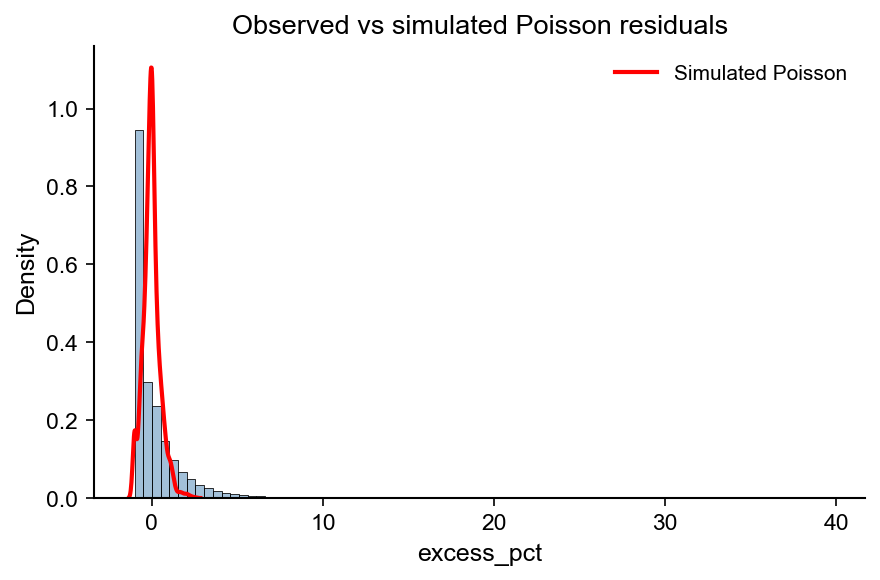

In [37]:
# With Simulation
sim = []
for mu in preds["mu_hat"].sample(2000, random_state=1):  # sample to save time
    y_sim = np.random.poisson(mu)
    sim.append((y_sim - mu) / max(mu, 1.0))
sim = np.array(sim)

# histogram your observed residuals
sns.histplot(preds["excess_pct"], bins=80, stat="density", color="steelblue", alpha=0.5)

# overlay KDE of simulated Poisson excess_pct
sns.kdeplot(sim, color="red", lw=2, label="Simulated Poisson")

plt.legend()
plt.xlabel("excess_pct")
plt.ylabel("Density")
plt.title("Observed vs simulated Poisson residuals")
plt.tight_layout()
plt.savefig('Observed_predicted.png', bbox_inches="tight")
plt.show()

In [29]:
# # ---------- Residual histogram with optional Poisson simulation ----------
# def plot_residual_histogram(preds_df, *, col="excess_pct", bins=80, xlim=None,
#                             logy=False, save_path="residual_hist.png", title=None,
#                             overlay_poisson=False, n_sim=2000, random_state=1):
#     """
#     Histogram of residual metrics. Default 'excess_pct'. 
#     For standardized residuals use col='z_std_jk'.

#     If overlay_poisson=True, simulate Poisson flows given mu_hat
#     and overlay the distribution of simulated residuals as a KDE line.
#     """
#     if col not in preds_df.columns:
#         raise ValueError(f"Column '{col}' not found in preds_df.")
#     x = pd.to_numeric(preds_df[col], errors="coerce").dropna().values

#     plt.figure(figsize=(6,4), dpi=150)
#     # observed histogram
#     sns.histplot(x, bins=bins, stat="density", color="steelblue", alpha=0.5, label="Observed")

#     if overlay_poisson:
#         if "mu_hat" not in preds_df.columns:
#             raise ValueError("Need 'mu_hat' in preds_df to simulate Poisson residuals.")
#         rng = np.random.default_rng(seed=random_state)
#         mus = preds_df["mu_hat"].dropna()
#         mus = mus.sample(min(n_sim, len(mus)), random_state=random_state).values
#         sim = []
#         for mu in mus:
#             y_sim = rng.poisson(mu)
#             sim.append((y_sim - mu) / max(mu, 1.0))
#         sim = np.array(sim)
#         # overlay KDE of simulated residuals
#         sns.kdeplot(sim, color="red", lw=2, label="Simulated Poisson")

#     if xlim is not None:
#         plt.xlim(xlim)
#     if logy:
#         plt.yscale("log")
#     if col.lower().startswith("z"):
#         plt.axvline(0, linestyle="--")
#         plt.axvline(2, linestyle=":")
#         plt.axvline(-2, linestyle=":")
#     plt.xlabel(col)
#     plt.ylabel("Density" if overlay_poisson else "Count")
#     plt.title(title or f"Distribution of {col}")
#     if overlay_poisson:
#         plt.legend()
#     plt.tight_layout()
#     plt.savefig(save_path, bbox_inches="tight")
#     plt.close()
#     return save_path

# # Normal histogram only
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 10),
#                         logy=True, save_path="resid_hist.png")

# # With simulated Poisson overlay
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 10),
#                         logy=True, overlay_poisson=True,
#                         n_sim=2000, save_path="resid_hist_overlay.png")


'resid_hist_overlay.png'

In [35]:
# # Export .csv for plot in R

# # Export validation curve
# vc = export_validation_curve(cf, "val_curve.csv")

# # Export predictions (+ masks so you can filter in R/ggplot)
# preds_out = export_preds_with_masks(cf, preds, "preds_with_masks.csv")

# # Export penalty report (JSON + bar-chart CSV)
# rep, groups = export_penalty_report(cf, flows, pops,
#                                     path_json="penalty_report.json",
#                                     path_csv="penalty_groups.csv")

# # Export residuals-only table (for a quick histogram elsewhere)
# res = export_residuals_only(preds, col="excess_pct", path_csv="residuals.csv")

## Result 

### Single

In [6]:
pred = pred_ALL

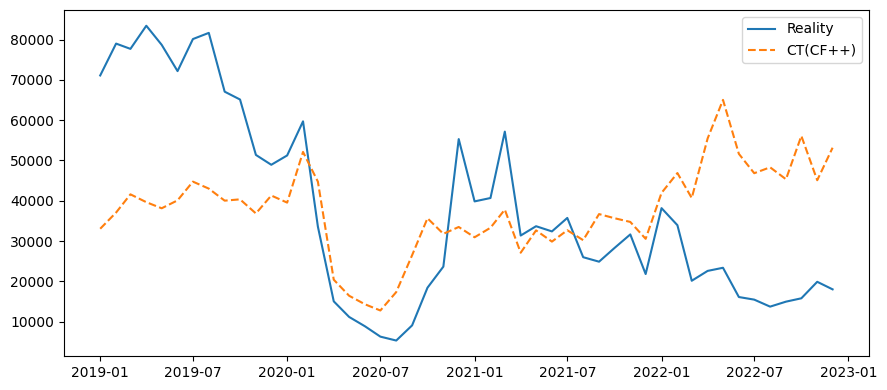

In [22]:
sub = pred[(pred.orig=="VE")&(pred.dest=="CO")].sort_values("month")
# sub = pred[(pred.orig=="DE")&(pred.dest=="FR")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

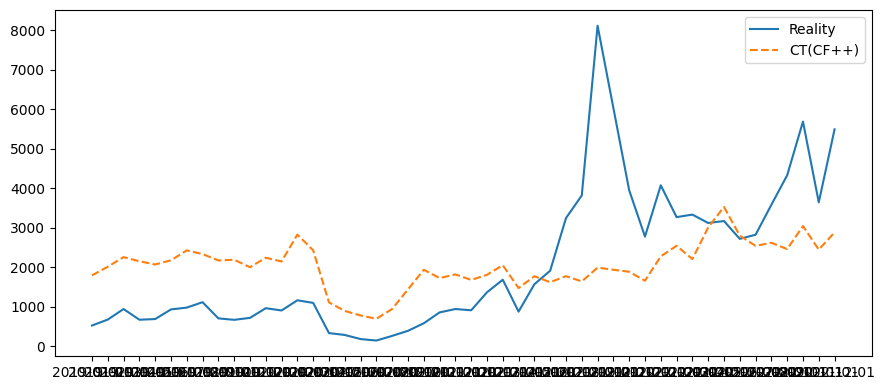

In [8]:
import matplotlib.pyplot as plt

sub = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()